# Title: #

# Introduction #


In [22]:
library(tidyverse)
library(repr)
library(tidymodels)

In [19]:
cleveland_data <- read_csv("https://raw.githubusercontent.com/mikayladitosto/dsci-100-2023s1-group-14/main/processed.cleveland.data", col_names = FALSE)
colnames(cleveland_data) <- c("age",
                              "sex",
                              "cp",
                              "trestbps",
                              "chol",
                              "fbs",
                              "restecg",
                              "thalach",
                              "exang",
                              "oldpeak",
                              "slope",
                              "ca",
                              "thal",
                              "num")
cleveland_data <- cleveland_data |>
    mutate(num = as_factor(num))
cleveland_data


Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [20]:
num_obs <- nrow(cleveland_data)
cleveland_data |>
  group_by(num) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )

num,count,percentage
<fct>,<int>,<dbl>
0,164,54.125413
1,55,18.151815
2,36,11.881188
3,35,11.551155
4,13,4.290429


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



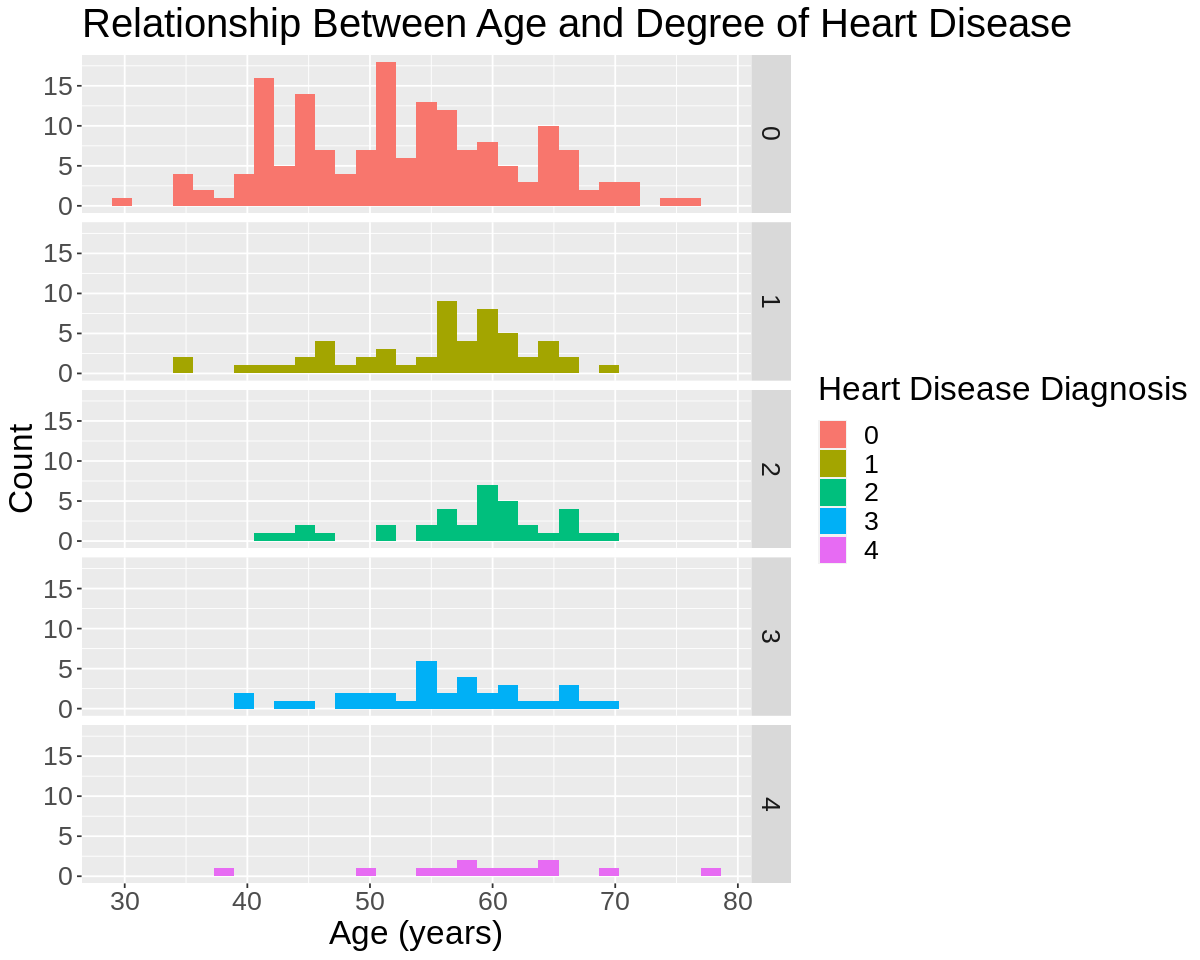

In [35]:
options(repr.plot.height = 8, repr.plot.width = 10)
age_hist <- ggplot(cleveland_data, aes(x = age, fill = num)) +
  geom_histogram(position = "identity") +
  facet_grid(rows = vars(num)) +
  labs(x = "Age (years)",
       y = "Count",
       fill = "Heart Disease Diagnosis") +
  ggtitle("Relationship Between Age and Degree of Heart Disease") +
  theme(text = element_text(size = 20))
age_hist